In [2]:
import matplotlib.pyplot as plt

# NN parameters
nn_name       = 'simple_model'
batch_size    = 100
epochs        = 100
valid_split   = 0.3
input_window  = 10
output_window = 1
l2_reg        = 8e-6
opt_params    = [0.001, # learning rate
                 1e-7]  # epsilon

In [3]:
from src.utils import data_handler

#dataset = data_handler.load_csv('/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv/direct_model.csv')
dataset = data_handler.load_csv('/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv/forward_profiles.csv')

In [4]:
train_data, valid_data, time = data_handler.window_data(dataset=dataset,
                                                  input_labels=['pedal',
                                                                'velocity'],
                                                  output_labels=['acceleration'],
                                                  input_window=input_window,
                                                  output_window=output_window,
                                                  batch_size=batch_size,
                                                  validation_split=valid_split)

# FC Model - No special activation

In [7]:
import numpy as np
np.shape(train_data[0])
#np.shape(train_data)
# (0,) - matrix corresponding to input_training_data
#       ==> (0=pedal,number_of_samples,input_window)    -  (array of pedal values) there are input_window NUMBER
#                                                          of these values all scaled forward by
#                                                          1 for each seperate array
#       ==> (1=velocity,number_of_samples,input_window) -
# (1,) - matrix corresponding to target_training_data
#       ==> (1,num_samples,1) - there is one array long the number of samples (acceleration outputs)


(2, 12700, 10)

In [8]:
train_data[0][0][0]

array([-0.99359965, -0.99359965, -0.9935996 , -0.99360037, -0.9936123 ,
       -0.9937081 , -0.994412  , -0.9972791 , -0.99350524, -0.9901724 ],
      dtype=float32)

In [9]:
# Weights initializers
drag_init = np.ones(shape=(1, 1),
                    dtype=np.float32) # to make TF happy
fc_init   = np.ones(shape=(input_window, output_window),
                    dtype=np.float32)

weights_init = [drag_init,
                fc_init]

In [10]:
###########
# Imports #
###########

import numpy as np
import tensorflow as tf
from src.functions import initializers as ci  # i.e., custom initalizers
from src.functions.layers import ActivLin1D  # import the custom activation function

# Disable eager execution so as not to get compilation errors using symbolic tensors
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

#############
# Functions #
#############

def simple_model(batch_size, input_shape, output_shape, weights_init, l2_reg, opt_params):
    """
    Simple NN model for the direct vehicle dynamics.

    It implements the following scheme:

    velocity -> ^2 -> *drag_coeff ->
                                     + -> acceleration
    pedal    -> Fully connected   ->

    Arguments:
     - batch_size:   size of the batch [int];
     - input_shape:  shape of the inputs;
     - output_shape: shape of the output;
     - weights_init: list of weight initializers;
     - l2_reg:       L2 regularization;
     - opt_params:   list of parameters for the optimizer [learning_rate, epsilon].

    Outputs:
     - model: Keras NN model of the aforementioned scheme.
    """

    # -- INPUTS --
    # Input() is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor - like object, which we augment
    # with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model.
    input_vx = tf.keras.layers.Input(shape=input_shape,
                                     batch_size=batch_size,
                                     name='input_vx')
    input_p = tf.keras.layers.Input(shape=input_shape,
                                    batch_size=batch_size,
                                    name='input_p')

    # -- INITIALIZERS --
    # Initializers define the way to set the initial random weights of Keras layers.
    drag_init = ci.MyInitializer(weights_init[0])
    fc_init = ci.MyInitializer(weights_init[1])

    # -- VELOCITY --
    # Square the input velocity :
    input_vx_squared = tf.keras.layers.Multiply()( [input_vx[:,-2:-1] , input_vx[:,-2:-1]] ) #take last element of the velocity
    # Multiply by the weights:
    vel_weighted = tf.keras.layers.Dense(units=1 , kernel_initializer=drag_init)(input_vx_squared)
    # Negative ReLU:
    ReLUed = -tf.keras.layers.ReLU()(vel_weighted)

    # -- PEDAL --
    # Add apply first neural layer:
    neural_layer_1 = tf.keras.layers.Dense(1 , kernel_initializer=fc_init)(input_p)
    # Apply second Neural layer
    #neural_layer_2 = tf.keras.layers.Dense(1)(neural_layer_1)

    # -- SUM ACCELERATION AND DRAG --
    #summed = tf.math.add(neural_layer_1 , ReLUed)
    summed = tf.keras.layers.Add()([neural_layer_1 , ReLUed])

    # -- OUTPUT OF MODEL --
    output = summed

    # Define the model
    model = tf.keras.Model(inputs=[input_vx, input_p],
                           outputs=output,
                           name='simple_model')

    # Optimizer parameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=opt_params[0],
                                         epsilon=opt_params[1])

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()]
                  )

    return model

In [11]:
dir_model = simple_model(batch_size=batch_size,
                                input_shape=input_window,
                                output_shape=output_window,
                                weights_init=weights_init,
                                l2_reg=l2_reg,
                                opt_params=opt_params)

Metal device set to: Apple M1


2023-01-25 17:57:48.627422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-25 17:57:48.627764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-25 17:57:48.638450: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-01-25 17:57:48.646396: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-25 17:57:48.657221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 17:57:48.692062: I tensorflow/core/grappler/optimizers/custom_graph

In [12]:
dir_model.summary()

Model: "simple_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_vx (InputLayer)          [(100, 10)]          0           []                               
                                                                                                  
 tf_op_layer_strided_slice (Ten  [(100, 1)]          0           ['input_vx[0][0]']               
 sorFlowOpLayer)                                                                                  
                                                                                                  
 tf_op_layer_strided_slice_1 (T  [(100, 1)]          0           ['input_vx[0][0]']               
 ensorFlowOpLayer)                                                                                
                                                                                       

In [17]:
# Callbacks
save_path  = f'/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/trained_models/{nn_name}/{nn_name}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    verbose=1,
                                                    save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=100,
                                                  verbose=1)

In [18]:
# Fix the random seed for reproducibility
tf.keras.utils.set_random_seed(314159)

history = dir_model.fit(x=train_data[0],
                       y=train_data[1],
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       callbacks=[checkpoint,
                                  early_stop],
                       validation_data=valid_data,
                       shuffle=True,
                       use_multiprocessing=True)

Train on 12700 samples, validate on 5500 samples
Epoch 1/100
12200/12700 [===========================>..] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0459
Epoch 1: val_loss improved from inf to 0.00783, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/trained_models/simple_model/simple_model.h5
12700/12700 [==============================] - 1s 63us/sample - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 2/100
12000/12700 [===========================>..] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0457
Epoch 2: val_loss improved from 0.00783 to 0.00782, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/trained_models/simple_model/simple_model.h5
12700/12700 [==============================] - 1s 64us/sample - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 3/100

In [19]:
save_path="/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/trained_models/simple_model/simple_model.h5"
best_model = tf.keras.models.load_model(filepath=save_path,
                                        custom_objects={
                                            'MyInitializer': ci.MyInitializer
                                            })

2023-01-25 18:02:24.702107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 18:02:24.712530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 18:02:24.726039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 18:02:24.774045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 18:02:24.786144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 18:02:24.796637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 18:02:24.812424: I tensorflow/core/grappler/optimizers/cust

/Users/francescomaraschin/.conda/envs/Project_NN_Conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-25 18:02:25.757836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


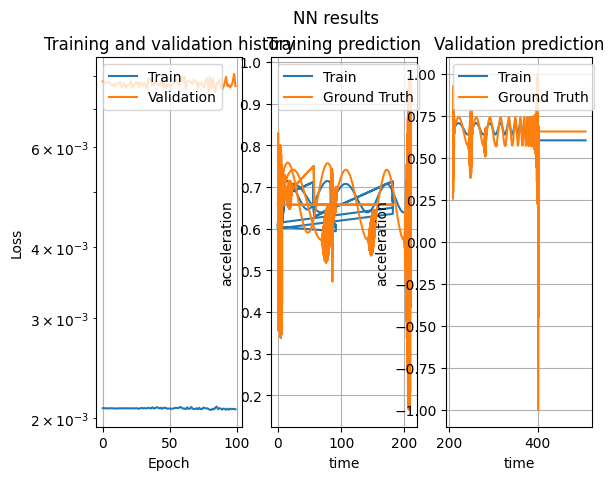

In [20]:
from src.utils import plotter

plotter.results(model=best_model,
               history=history,
               dataset=[train_data,
                        valid_data],
               time=time,
               batch_size=batch_size)

# Make a new dataset to test the model

In [21]:
import numpy as np
import matplotlib.pyplot as plt


In [22]:
# Make some data and save as csv file

time = np.linspace(0,100,100000)
my_pedal = np.sin(0.1*time)
noise = np.random.normal(0,0.01,np.size(my_pedal))
my_pedal = my_pedal #+ noise
my_velocity = np.sin(0.1*time)
my_acceleration = np.cos(0.1*time)

import csv

header = ['', 'pedal', 'velocity','acceleration']
data = [time , my_pedal , my_velocity , my_acceleration]

%cd /Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv
with open('my_csv.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    for i in range(np.size(time)):
        writer.writerow([data[0][i] , data[1][i] , data[2][i] , data[3][i]])


/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv


<AxesSubplot: >

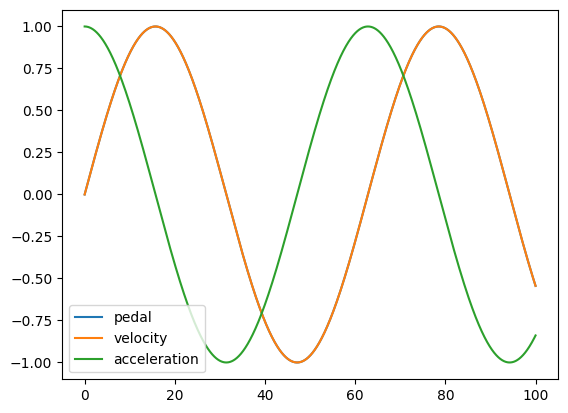

In [23]:
# plot my data
csv_path = "/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/csv/my_csv.csv"
my_data = data_handler.load_csv(csv_path)
my_data.plot()

In [24]:
# Window the data:

from src.utils.data_handler import window_data

my_train_data , my_valid_data , my_time = window_data(dataset=my_data,
                                                      input_labels=['pedal' , 'velocity'],
                                                      output_labels=['acceleration'],
                                                      input_window=10,
                                                      output_window=1,
                                                      batch_size=100,
                                                      validation_split=1)

In [25]:
# Predict with model:
my_predictions = best_model.predict(my_valid_data[0])

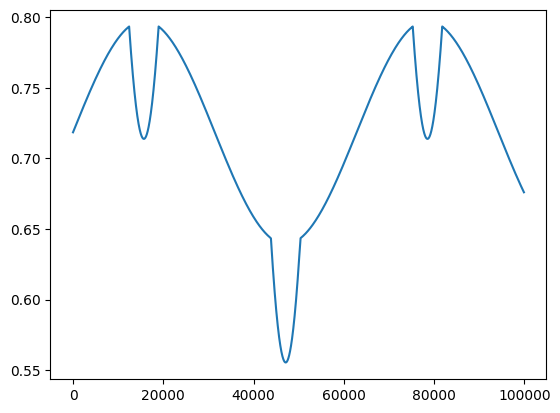

In [26]:
plt.plot(my_predictions)
